# Last Mile Delivery Scheduling Problem

We will build an optimization model to solve this problem. Let's first write out the math formulation. 

<br>

<b>Sets: </b>

Employees: $i \in I=\{1,...,19 \}$

Jobs: $j, k \in \Theta =\{1,...,49 \}$ 

<br>

<b>Parameters:</b>

$JS_j$: job $j$ starttime

$JE_j$: job $j$ endtime

$SS_i$: time of employee $i$ starts shift

$SE_i$: time of employee $i$ ends shift

<br>

<b>Decision variables:</b>

$
x_{ij} = \left\{
    \begin{array}\\
        1 & \text{if job } j \text{ is assigned to employee } i \\
        0 & otherwise \\
    \end{array}
\right.
$

$
z_{ijk} = \left\{
    \begin{array}\\
        1 & \text{ job } j \text{ starts before job } k,\text{ done by employee }i \\
        0 & \text{ job } j \text{ starts after job } k,\text{ done by employee }i \\
    \end{array}
\right.
$

The problem can be solved as the following MIP.

\begin{align}
	\text{Maximize:} \quad & \sum_{i \in I} \sum_{j \in \Theta} x_{ij} \\    
	\text{Subject to:} \quad & \sum_{j \in \Theta} x_{ij} \leq 1, \quad\qquad\qquad\qquad\qquad\quad \forall j \\    
    & x_{ij} \cdot (JS_j - SS_i) \geq 0, \qquad\qquad\qquad \forall i,j \\    
    & x_{ij} \cdot (SE_i - JE_j) \geq 0, \qquad\qquad\qquad \forall i,j \\
	& x_{ij} \cdot JS_j \geq x_{ik} \cdot JE_k - M \cdot z_{ijk}, \quad\qquad \forall i,j, k \ and\  j <k\\
    & x_{ik} \cdot JS_k \geq x_{ij} \cdot JE_j - M \cdot (1-z_{ijk}), \quad \forall i,j, k \ and\  j <k\\
\end{align}

In [1]:
# This routine will need Gurobi to be installed
# conda config --add channels https://conda.anaconda.org/gurobi
# conda install gurobi

In [2]:
import pandas as pd
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import datetime
import matplotlib.pyplot as plt

In [3]:
ev = pd.read_excel('input/data_carvana.xlsx',sheet_name='events')
dur = pd.read_excel('input/data_carvana.xlsx',sheet_name='duration')
res = pd.read_excel('input/data_carvana.xlsx',sheet_name='resources')

In [4]:
res.head()

,ResourceId,StartTime,EndTime
0,9454310,07:00:00,19:00:00
1,10541233,07:00:00,17:00:00
2,9061975,07:00:00,17:00:00
3,7840175,07:00:00,17:00:00
4,10683867,07:00:00,17:00:00


In [5]:
dur.columns

Index(['OriginAddressId', 'DestinationAddressId',
       'TripDuration(hour:minute:second)', 'Unnamed: 3', 'Unnamed: 4',
       'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8'],
      dtype='object')

In [6]:
# Events to be scheduled 
ev = ev.drop(['Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7'],axis=1)

In [7]:
# Durations
dur = dur.drop(['Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8'], axis=1)

In [8]:
ev.head()

,EventId,Appointment Starttime,Appointment Endtime,AddressId
0,8366991,08:15:00,10:15:00,A1
1,8536889,08:15:00,10:15:00,A2
2,8293270,08:22:30,10:07:30,A3
3,8318992,08:22:30,11:22:30,A4
4,1563930,08:57:30,10:32:30,A5


In [9]:
dur.columns = ['OriginAddressId', 'AddressId', 'TripDuration']

In [10]:
# Merge "Events" and "Durations" to be "jobs"
jobs = pd.merge(ev, dur, on='AddressId')

In [11]:
jobs = jobs.drop('OriginAddressId',axis=1)

In [12]:
jobs.head()

,EventId,Appointment Starttime,Appointment Endtime,AddressId,TripDuration
0,8366991,08:15:00,10:15:00,A1,00:30:00
1,8536889,08:15:00,10:15:00,A2,00:30:00
2,8293270,08:22:30,10:07:30,A3,00:22:30
3,8318992,08:22:30,11:22:30,A4,00:52:30
4,1563930,08:57:30,10:32:30,A5,00:27:30


In [13]:
# Convert datetime.time format to seconds
def time_to_seconds(time):
    return (time.hour * 60 + time.minute) * 60 + time.second

In [14]:
# resource = {resourceID: [ShiftStart, ShiftEnd], ... }
resource = {}
for i in range(len(res.index)):
    resource[res['ResourceId'][i]] = [time_to_seconds(res['StartTime'][i]), time_to_seconds(res['EndTime'][i]) ]

In [15]:
# events = {eventID: [AppStart, AppEnd], ... }
events = {}
for i in range(len(ev.index)):
    events[jobs['EventId'][i]] = [time_to_seconds(jobs['Appointment Starttime'][i]), 
                                  time_to_seconds(jobs['Appointment Endtime'][i]) ]

In [16]:
# Pre-processing data for solving MIP in Gurobi
emp_num, shift_start, shift_end = gp.multidict(resource)
job_num, job_start, job_end = gp.multidict(events)

In [17]:
availability=[]
for i in emp_num:
    for j in job_num:
        availability.append((i,j))

In [18]:
bigM = 100000   # 1 day = 86400 seconds. 

In [19]:
# Model
m = gp.Model("carvana_schedule")

Academic license - for non-commercial use only - expires 2021-06-18
Using license file C:\Users\freed\gurobi.lic


In [20]:
# Decision var: x[emp_num, job_num]
x = m.addVars(availability, vtype = GRB.BINARY, name="x")

In [21]:
# Decision var: z[emp_num, job_num, job_num] 
z = m.addVars(emp_num, job_num, job_num, vtype = GRB.BINARY, name="z")

In [22]:
# Objective 
m.setObjective(gp.quicksum(x[i] for i in availability), GRB.MAXIMIZE)

In [23]:
# contranit (1): Each job can only be done by no more than ONE employee
m.addConstrs( (x.sum('*',s) <= 1 for s in job_num), "eachjob")

{8366991: <gurobi.Constr *Awaiting Model Update*>,
 8536889: <gurobi.Constr *Awaiting Model Update*>,
 8293270: <gurobi.Constr *Awaiting Model Update*>,
 8318992: <gurobi.Constr *Awaiting Model Update*>,
 1563930: <gurobi.Constr *Awaiting Model Update*>,
 8528952: <gurobi.Constr *Awaiting Model Update*>,
 1566611: <gurobi.Constr *Awaiting Model Update*>,
 1566612: <gurobi.Constr *Awaiting Model Update*>,
 8502088: <gurobi.Constr *Awaiting Model Update*>,
 8455723: <gurobi.Constr *Awaiting Model Update*>,
 1546739: <gurobi.Constr *Awaiting Model Update*>,
 8513010: <gurobi.Constr *Awaiting Model Update*>,
 1547686: <gurobi.Constr *Awaiting Model Update*>,
 1540296: <gurobi.Constr *Awaiting Model Update*>,
 8526555: <gurobi.Constr *Awaiting Model Update*>,
 8495159: <gurobi.Constr *Awaiting Model Update*>,
 8511033: <gurobi.Constr *Awaiting Model Update*>,
 8530434: <gurobi.Constr *Awaiting Model Update*>,
 8370070: <gurobi.Constr *Awaiting Model Update*>,
 8550751: <gurobi.Constr *Await

In [24]:
# contranit (2)(3): Each scheduled job must be within that employee's shift hours.
for i in emp_num:
    for j in job_num:
        m.addConstr( x[i, j] * (job_start[j] - shift_start[i]) >= 0 , "workhour1[%s, %s]"%(i, j) )
        m.addConstr( x[i, j] * (job_end[j] - shift_end[i]) <= 0 , "workhour2[%s, %s]"%(i, j) )

In [25]:
# contranit (4)(5): Disjunctive constraints: for employee i, scheduled job j and k cannot overlap. 
for i in emp_num:
    for j in job_num:
        for k in job_num: 
            if j<k:
                #print(i,j,k)
                m.addConstr( x[i,j]*job_start[j] >= x[i,k]*job_end[k] - bigM*z[i,j,k] , "disjunctive1[%s, %s, %s]"%(i, j, k) )
                m.addConstr( x[i,k]*job_start[k] >= x[i,j]*job_end[j] - bigM*(1-z[i,j,k]) , "disjunctive2[%s, %s, %s]"%(i, j, k) )

In [26]:
# Solve
m.optimize()    

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 46599 rows, 46550 columns and 136843 nonzeros
Model fingerprint: 0x4635de26
Variable types: 0 continuous, 46550 integer (46550 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+05]
Found heuristic solution: objective 1.0000000
Found heuristic solution: objective 2.0000000
Presolve removed 46247 rows and 45773 columns
Presolve time: 0.20s
Presolved: 352 rows, 777 columns, 4417 nonzeros
Variable types: 0 continuous, 777 integer (777 binary)

Root relaxation: objective 4.900000e+01, 167 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      49.0000000   49.00000  0.00%     

In [27]:
# print results
solution = m.getAttr('x',x)

print('Total numbers of events scheduled: %g' % m.objVal)

schedule = pd.DataFrame(columns=['ResourceId','EventId','Appointment Starttime','Appointment Endtime'])

for i in emp_num:
    for j in job_num:
        if solution[i,j] == 1:
            schedule.loc[len(schedule.index)] = [i,j, ev.at[ev[ev['EventId'] == j].index[0], 'Appointment Starttime'], ev.at[ev[ev['EventId'] == j].index[0], 'Appointment Endtime']] 
            #print('Employee %s takes event %s' % (i, j))

schedule.to_excel("LastMileDeliverySchedule_XH.xlsx")  
schedule.head()

Total numbers of events scheduled: 49


,ResourceId,EventId,Appointment Starttime,Appointment Endtime
0,9454310,8502088,09:00:00,11:00:00
1,9454310,8550751,11:45:00,14:00:00
2,9454310,8544795,14:30:00,17:30:00
3,10541233,8293270,08:22:30,10:07:30
4,10541233,8206275,11:37:30,15:07:30


In [28]:
employees = sorted(list(schedule['ResourceId'].unique()))

In [29]:
# Dictionary: emp_sch = {ResourceId1: [(AppStart1, AppDur1), (AppStart2, AppDur2), (AppStart3, AppDur3)... ], 
#                        ResourceId2: [(), ()],
#                        ...               }
emp_sch = {}
for i in employees:
    emp_sch[i] = []
    for st in list( schedule[schedule['ResourceId'] == i]['Appointment Starttime']):
        emp_sch[i].append( (time_to_seconds(st), time_to_seconds(schedule.at[schedule[schedule['Appointment Starttime'] == st].index[0], 'Appointment Endtime'])- time_to_seconds(st) ) )

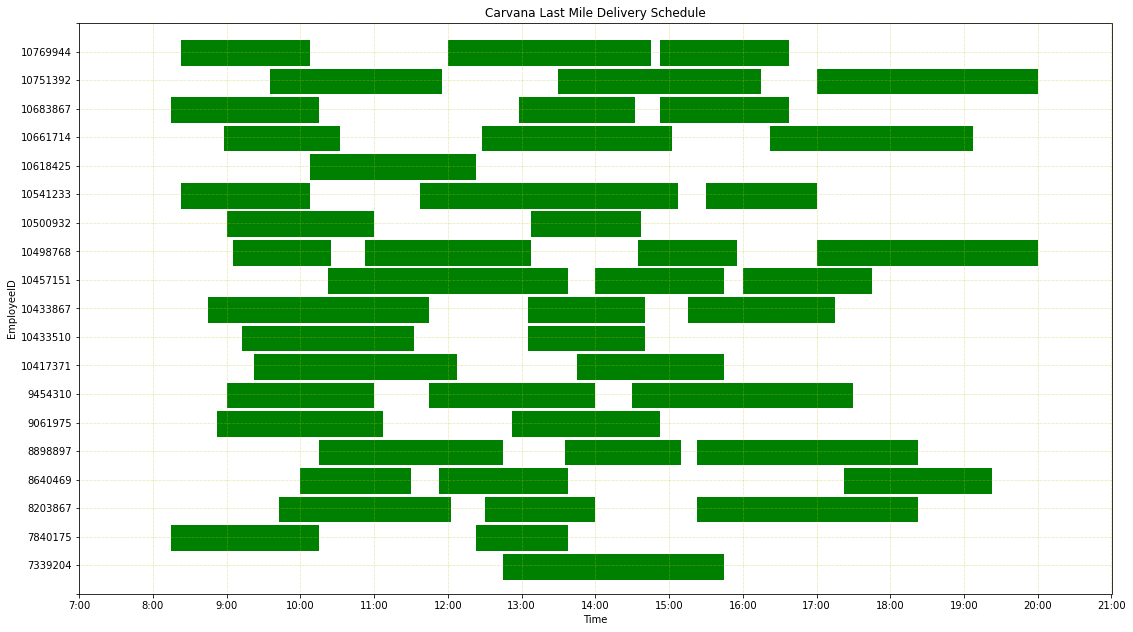

In [30]:
fig, gnt = plt.subplots()

fig.set_size_inches(18.5, 10.5)
gnt.set_ylim(0, 10+10*len(employees))
gnt.set_xlim(30000, 70000)
plt.title("Carvana Last Mile Delivery Schedule")
gnt.set_xlabel('Time')
gnt.set_ylabel('EmployeeID')

# Setting x axis
gnt.set_xticks( list(range(25200,79200,3600)) ) # 7:00 - 22:00
gnt.set_xticklabels(['7:00', '8:00', '9:00', '10:00', '11:00', '12:00', '13:00', '14:00', 
                     '15:00', '16:00', '17:00', '18:00', '19:00', '20:00', '21:00'])

# Setting y axis
gnt.set_yticks( list(range(0, 10*len(employees)+20, 10 )) )
emp_labels = employees.copy()
emp_labels.insert(0,'')
emp_labels.append('')
gnt.set_yticklabels(emp_labels)

gnt.grid(True, color = 'tab:olive', linestyle = ':', linewidth = 0.5)

for h, i in enumerate(emp_sch):
    gnt.broken_barh(emp_sch[i], (5+10*h, 9), facecolors =('green'))
    
plt.savefig("CarvanaSchedule.png")